# Cross-subject classification

This is an example of how one might pool data from multiple subjects in order to look for ERPs and run classification pipelines.

The `utils.load_data` function will load multiple subjects data for the same experiment into the same Raw data structure by simply providing it's `subject_nb` argument with an array of subject numbers

In [6]:
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws, concatenate_epochs
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt
from mne import Epochs, find_events

sys.path.append(os.path.join(os.path.expanduser("~"), "eeg-notebooks", 'utils'))
import utils

%matplotlib inline

## Read data and convert them in MNE objects

Data is saved in csv file for more convenience. Then we will convert them into MNE data object so we can pre-process and epoch them

In [7]:
all_epochs = []
subjects = [1, 2]

for subject in subjects:
    raw = utils.load_data('visual/P300', sfreq=256., 
                          subject_nb=subject, session_nb='all', 
                          ch_ind=[0, 1, 2, 3])
    
    raw.filter(1, 30, method='iir')

    events = find_events(raw)
    event_id = {'Non-Target': 1, 'Target': 2}

    epochs = Epochs(raw, events=events, event_id=event_id, tmin=-0.1, 
                    tmax=0.8, baseline=None, reject={'eeg': 100e-6}, 
                    preload=True, verbose=False, picks=[0,1,2,3], add_eeg_ref=False)
    all_epochs.append(epochs)

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ..

## Epoch average

Now we can plot the average ERP for both conditions, and see if there is something

4557 matching events found


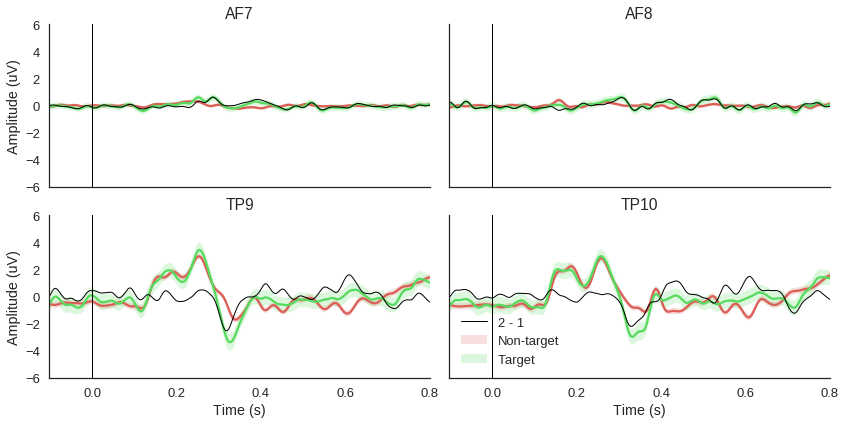

In [8]:
conditions = OrderedDict()
conditions['Non-target'] = [1]
conditions['Target'] = [2]

epochs = concatenate_epochs(all_epochs)

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

There's a pretty nice P300 visible here, along with some VEP components around 100 and 200ms

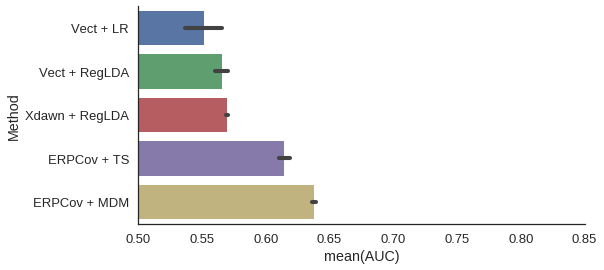

In [4]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(4, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

X = [epochs.copy().pick_types(eeg=True).get_data() for epochs in all_epochs]
y = [epochs.events[:, -1] for epochs in all_epochs]
subjects = [[ii]*len(x) for ii, x in enumerate(X)]

X = np.concatenate(X)
y = np.concatenate(y)
subjects = np.concatenate(subjects)


# define cross validation 
cv = LeaveOneGroupOut()

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, groups=subjects, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.5, 0.85)
sns.despine()

However, you'll notice the classification accuracy is decreased significantly compared to single subject analysis with the same data